<a href="https://colab.research.google.com/github/fabrihayra/Google-Advanced-Analytics-Codes/blob/main/Bike_Sharing_Prediction_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import csv
import sys
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

### Introduction:
This project aims to develop a Neural Network that predicts the number of bike rentals required on a specific day. This prediction will be based on historical data spanning from January 1, 2011, to December 31, 2012. The ultimate goal is to ensure the optimal number of bikes are available to meet daily demand.

In [5]:
DATASET_DIRECTORY = "./bike-sharing/"

if os.path.isdir(DATASET_DIRECTORY):
    print("Bike-Sharing dataset found in directory '" + DATASET_DIRECTORY + "':")
    for file in os.listdir(DATASET_DIRECTORY):
        print("- "  + file)
else:
    print("Missing 'bike-sharing' data folder!")

Bike-Sharing dataset found in directory './bike-sharing/':
- day.csv
- hour.csv


In [8]:
ride_data = pd.read_csv(os.path.join(DATASET_DIRECTORY, "hour.csv"))

In [9]:
print("Present fields:")
ride_data.head(10)

Present fields:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


Visualizing data for the first 30 days...


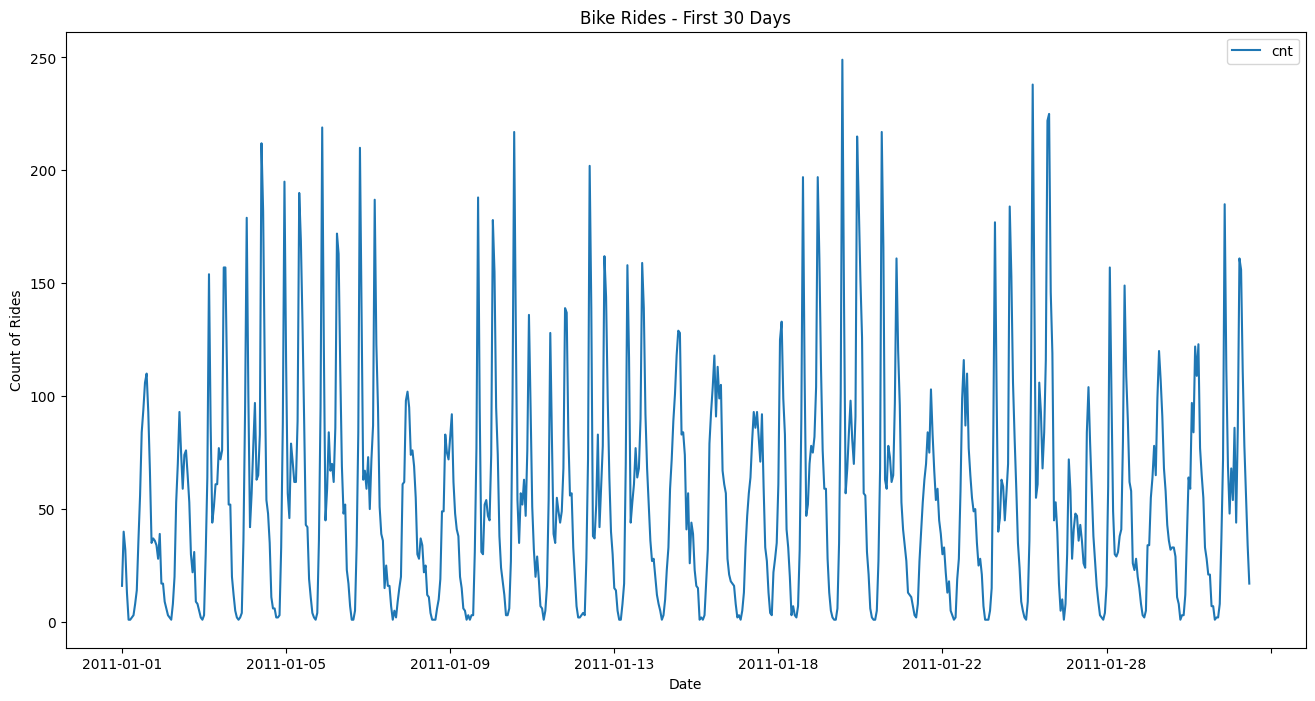

In [10]:
def plot_first_30_days(data):
    """Plot bike rides data for the first 30 days."""
    first_30_days = data[data["dteday"] < "2011-02-01"]
    ax = first_30_days.plot(figsize=(16, 8), x="dteday", y="cnt", title="Bike Rides - First 30 Days")
    ax.set_ylabel("Count of Rides")
    ax.set_xlabel("Date")
    plt.show()

print("Visualizing data for the first 30 days...")
plot_first_30_days(rides_data)


**Data Preprocessing: Introducing Dummy Variables**

Neural networks operate on numerical values, processing them through matrix multiplications and subsequent adjustments to achieve desired outputs. Non-numerical data, such as categorical strings, are incompatible with this computation process.

Take, for instance, a "Weekday" field with values like "Monday", "Tuesday", and so on. We can't directly feed these string values into the network. Instead, we transform such fields using a technique called "one-hot encoding". This involves converting each unique category into its own binary (0 or 1) field. So, "Weekday" would be split into seven separate fields: "Monday", "Tuesday", etc., where each field indicates the presence (1) or absence (0) of that particular day.

In [12]:
# Demonstrating how to convert a categorical column to dummy variables
print(f"Converting 'weekday' column to dummy variables:")
weekday_dummy_example = pd.get_dummies(ride_data["weekday"], prefix="weekday", drop_first=False)

# Displaying the first row to show the transformation
print(weekday_dummy_example.head(1))

Converting 'weekday' column to dummy variables:
   weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6
0          0          0          0          0          0          0          1


In [14]:
# Print the column names before creating dummy variables
print("Before creating dummies:")
print(', '.join(ride_data.columns))

Before creating dummies:
instant, dteday, season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt


In [16]:
def create_dummies(dataframe, fields):
    """
    Convert specified fields in a DataFrame into dummy variables.
    Parameters:
    - dataframe (pd.DataFrame): The original DataFrame.
    - fields (list): List of column names in the DataFrame to be converted into dummy variables.
    Returns:
    - pd.DataFrame: DataFrame with added dummy variable columns.
    """
    preprocessed_dataframe = dataframe.copy()
    dummies_list = []

    for field in fields:
        dummies = pd.get_dummies(preprocessed_dataframe[field], prefix=field, drop_first=False)
        dummies_list.append(dummies)
        preprocessed_dataframe.drop(field, axis=1, inplace=True)

    # Concatenate all dummies at once
    preprocessed_dataframe = pd.concat([preprocessed_dataframe] + dummies_list, axis=1)

    return preprocessed_dataframe

In [20]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
rides_data_preprocessed = create_dummies(ride_data, dummy_fields)

print(rides_data_preprocessed.head())

   instant      dteday  yr  holiday  workingday  temp   atemp   hum  \
0        1  2011-01-01   0        0           0  0.24  0.2879  0.81   
1        2  2011-01-01   0        0           0  0.22  0.2727  0.80   
2        3  2011-01-01   0        0           0  0.22  0.2727  0.80   
3        4  2011-01-01   0        0           0  0.24  0.2879  0.75   
4        5  2011-01-01   0        0           0  0.24  0.2879  0.75   

   windspeed  casual  ...  hr_21  hr_22  hr_23  weekday_0  weekday_1  \
0        0.0       3  ...      0      0      0          0          0   
1        0.0       8  ...      0      0      0          0          0   
2        0.0       5  ...      0      0      0          0          0   
3        0.0       3  ...      0      0      0          0          0   
4        0.0       0  ...      0      0      0          0          0   

   weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          0          1  
1          0          

In [21]:
# Print the column names after creating dummy variables
print("After creating dummies:")
print(', '.join(rides_data_preprocessed.columns))

After creating dummies:
instant, dteday, yr, holiday, workingday, temp, atemp, hum, windspeed, casual, registered, cnt, season_1, season_2, season_3, season_4, weathersit_1, weathersit_2, weathersit_3, weathersit_4, mnth_1, mnth_2, mnth_3, mnth_4, mnth_5, mnth_6, mnth_7, mnth_8, mnth_9, mnth_10, mnth_11, mnth_12, hr_0, hr_1, hr_2, hr_3, hr_4, hr_5, hr_6, hr_7, hr_8, hr_9, hr_10, hr_11, hr_12, hr_13, hr_14, hr_15, hr_16, hr_17, hr_18, hr_19, hr_20, hr_21, hr_22, hr_23, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6


In [22]:
def normalize_fields(dataframe, fields):
    """
    Normalize specified fields in a DataFrame using Z-score normalization.
    Parameters:
    - dataframe (pd.DataFrame): The original DataFrame.
    - fields (list): List of column names in the DataFrame to be normalized.
    Returns:
    - pd.DataFrame: DataFrame with normalized fields.
    - dict: Dictionary with the mean and standard deviation used for each field's normalization.
    """
    normalized_dataframe = dataframe.copy()
    normalized_fields = {}

    for field in fields:
        mean, std = dataframe[field].mean(), dataframe[field].std()
        normalized_fields[field] = [mean, std]
        normalized_dataframe[field] = (dataframe[field] - mean) / std

    return normalized_dataframe, normalized_fields


In [24]:
# List of columns in the dataframe to be normalized
numerical_values = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Normalize specified columns and retrieve normalization parameters
rides_data_preprocessed, normalization_info = normalize_fields(rides_data_preprocessed, numerical_values)

In [25]:
for field in numerical_values:
    mean = rides_data_preprocessed.loc[:, field].mean()
    std = rides_data_preprocessed.loc[:, field].std()
    print(f"- Normalized values in field: {field}, mean: {mean:.4f}, std: {std:.4f}")


- Normalized values in field: casual, mean: 0.0000, std: 1.0000
- Normalized values in field: registered, mean: 0.0000, std: 1.0000
- Normalized values in field: cnt, mean: 0.0000, std: 1.0000
- Normalized values in field: temp, mean: -0.0000, std: 1.0000
- Normalized values in field: hum, mean: -0.0000, std: 1.0000
- Normalized values in field: windspeed, mean: -0.0000, std: 1.0000


Given these results:

- The mean value close to
0
0 confirms that the data has been centered around zero.
- The standard deviation of
1 confirms that the data has been scaled in a manner such that the spread (variability) of each field's data points is consistent.



---


**Data Splitting: Training, Validation, and Testing Sets**
Given the sequential nature of our historical data, it's essential for the neural network to learn from past data and accurately predict future outcomes. To achieve this:
- We'll use December 2012 data as our test set to evaluate the model's performance on unseen recent data.
- Data from October and November 2012 will serve as the validation set, aiding in model tuning and preventing overfitting during training.
- All preceding data will be allocated to the training set, providing a comprehensive foundation for the model to learn.

In [26]:
test_data = rides_data_preprocessed.loc[rides_data_preprocessed["dteday"] >= "2012-12-01"]
validation_data = rides_data_preprocessed.loc[(rides_data_preprocessed["dteday"] >= "2012-10-01") & (rides_data_preprocessed["dteday"] < "2012-12-01")]
train_data = rides_data_preprocessed.loc[rides_data_preprocessed["dteday"] < "2012-10-01"]


In [28]:
print(f"Test data samples: {test_data.shape[0]}")
print(f"Validation data samples: {validation_data.shape[0]}")
print(f"Train data samples: {train_data.shape[0]}")

Test data samples: 742
Validation data samples: 1426
Train data samples: 15211


**Dropping unused fields:**

In [33]:
def drop_fields(dataframe, fields):
    """Drop specified fields from a DataFrame if they exist."""
    fields_to_drop = [field for field in fields if field in dataframe.columns]
    return dataframe.drop(columns=fields_to_drop)


In [34]:
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit',
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']

test_data = drop_fields(test_data, fields_to_drop)
val_data = drop_fields(validation_data, fields_to_drop)
train_data = drop_fields(train_data, fields_to_drop)

**Split data - features, targets:**

In [35]:
def split_features_targets(data, target_columns):
    """Splits a DataFrame into features and targets based on specified target columns."""
    features = data.drop(columns=target_columns)
    targets = data[target_columns]
    return features, targets

# Columns treated as target variables (or labels)
target_fields = ['cnt', 'casual', 'registered']

# Splitting the data into features and targets
test_features, test_targets = split_features_targets(test_data, target_fields)
val_features, val_targets = split_features_targets(val_data, target_fields)
train_features, train_targets = split_features_targets(train_data, target_fields)


**Neural Network:**

In [37]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate

        self.initialize_weights_and_biases()

    def initialize_weights_and_biases(self):
        # He initialization
        self.weights_i_to_h = np.random.randn(self.input_nodes, self.hidden_nodes) * np.sqrt(2. / self.input_nodes)
        self.bias_i_to_h = np.zeros(self.hidden_nodes)

        self.weights_h_to_o = np.random.randn(self.hidden_nodes, self.output_nodes) * np.sqrt(2. / self.hidden_nodes)
        self.bias_h_to_o = np.zeros(self.output_nodes)

    def activation_sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward_pass(self, X):
        # Input to hidden layer
        hidden_inputs = np.dot(X, self.weights_i_to_h) + self.bias_i_to_h
        hidden_outputs = self.activation_sigmoid(hidden_inputs)

        # Hidden layer to output
        final_inputs = np.dot(hidden_outputs, self.weights_h_to_o) + self.bias_h_to_o
        final_outputs = final_inputs  # Linear activation

        return hidden_outputs, final_outputs

    def backward_pass(self, X, y, hidden_outputs, final_outputs):
        error = y - final_outputs
        output_error_term = error  # Since f'(x) = 1 for the output layer

        hidden_error = np.dot(output_error_term, self.weights_h_to_o.T)
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

        return output_error_term, hidden_error_term

    def train(self, features, targets):
        n_records = features.shape[0]

        delta_weights_i_h = np.zeros(self.weights_i_to_h.shape)
        delta_weights_h_o = np.zeros(self.weights_h_to_o.shape)
        delta_bias_i_h = np.zeros(self.bias_i_to_h.shape)
        delta_bias_h_o = np.zeros(self.bias_h_to_o.shape)

        for X, y in zip(features, targets):
            hidden_outputs, final_outputs = self.forward_pass(X)
            output_error_term, hidden_error_term = self.backward_pass(X, y, hidden_outputs, final_outputs)

            delta_weights_i_h += hidden_error_term * X[:, None]
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        self.update_weights_and_biases(n_records, delta_weights_i_h, delta_weights_h_o)

    def update_weights_and_biases(self, n_records, delta_weights_i_h, delta_weights_h_o):
        self.weights_i_to_h += self.lr * delta_weights_i_h / n_records
        self.weights_h_to_o += self.lr * delta_weights_h_o / n_records

    def run(self, features):
        _, final_outputs = self.forward_pass(features)
        return final_outputs


**Loss Function:**

In [38]:
def MSE(predcition, target):
    return np.mean((predcition - target) ** 2)

**Mini Batches:**

In [40]:
def prepare_mini_batches(df_features, df_targets, batch_size):
    data = df_features.values
    labels = df_targets.values
    assert len(data) == len(labels)

    # Shuffle the indices
    shuffled_indices = np.random.permutation(len(data))
    data = data[shuffled_indices]
    labels = labels[shuffled_indices]

    # Create mini batches
    mini_batches = []
    num_full_batches, remainder = divmod(len(data), batch_size)

    for i in range(num_full_batches):
        mini_batches.append((data[i*batch_size:(i+1)*batch_size],
                             labels[i*batch_size:(i+1)*batch_size]))

    # Add the last batch if there's any remainder
    if remainder:
        mini_batches.append((data[num_full_batches*batch_size:],
                             labels[num_full_batches*batch_size:]))

    return mini_batches

**Hyperparameters:**

In [41]:
# Hyperparameters and architecture details
epochs = 100
batch_size = 128
learning_rate = 0.5
input_nodes = 56
hidden_nodes = 25
output_nodes = 1

**Training Loop:**

The outer loop iterates through epochs. For each epoch:

- Mini-batches are prepared.
- Each mini-batch is used to train the network.
- The training loss (MSE) for that mini-batch is computed and stored.
- After all mini-batches for the epoch are processed, the average training loss for the epoch is computed.
- Validation loss is then computed.
- Both training and validation losses for the epoch are printed.

In [42]:
%%time

network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

info = {'train':[], 'validation':[]}
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(train_features, train_targets['cnt'], batch_size)

    epoch_losses = []
    while mini_batches:
        data_batch, labels_batch = mini_batches.pop()
        network.train(data_batch, labels_batch)

        batch_train_loss = MSE(network.run(data_batch).T, labels_batch)
        epoch_losses.append(batch_train_loss)

    train_loss = np.mean(epoch_losses)
    info['train'].append(train_loss)

    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    info['validation'].append(val_loss)

    # Print losses every 10 epochs to declutter output
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch: {epoch + 1}/{epochs}:\n"
              f"      - Training loss: {train_loss:.4f}\n"
              f"      - Validation loss: {val_loss:.4f}")


Epoch: 1/100:
      - Training loss: 2.0336
      - Validation loss: 1.0246
Epoch: 11/100:
      - Training loss: 0.1540
      - Validation loss: 0.3025
Epoch: 21/100:
      - Training loss: 0.0709
      - Validation loss: 0.1728
Epoch: 31/100:
      - Training loss: 0.0587
      - Validation loss: 0.1606
Epoch: 41/100:
      - Training loss: 0.0545
      - Validation loss: 0.1613
Epoch: 51/100:
      - Training loss: 0.0524
      - Validation loss: 0.1554
Epoch: 61/100:
      - Training loss: 0.0508
      - Validation loss: 0.1603
Epoch: 71/100:
      - Training loss: 0.0496
      - Validation loss: 0.1464
Epoch: 81/100:
      - Training loss: 0.0487
      - Validation loss: 0.1579
Epoch: 91/100:
      - Training loss: 0.0479
      - Validation loss: 0.1518
Epoch: 100/100:
      - Training loss: 0.0472
      - Validation loss: 0.1615
CPU times: user 1min 1s, sys: 8.93 s, total: 1min 10s
Wall time: 1min 4s


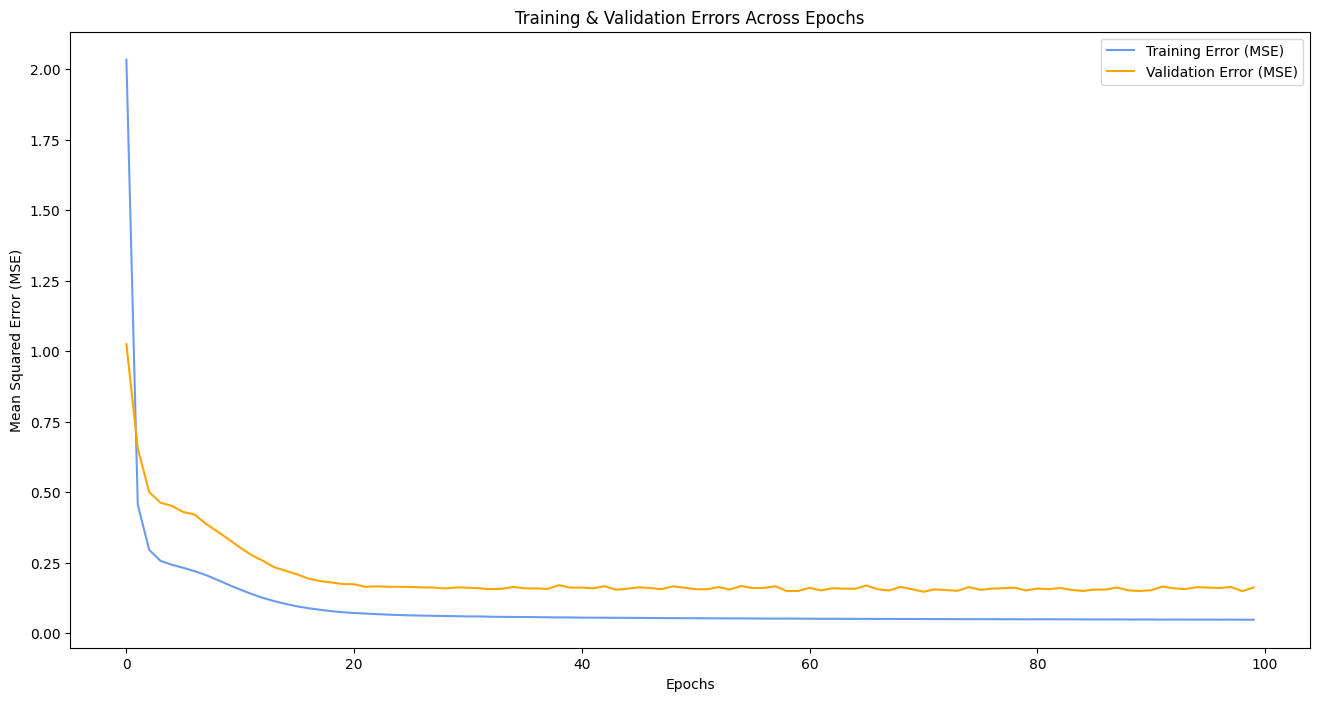

In [43]:
# Setting up the plot size
plt.figure(figsize=(16, 8))

# Plotting training and validation errors
plt.plot(info['train'], label='Training Error (MSE)', color='#699cef')
plt.plot(info['validation'], label='Validation Error (MSE)', color='orange')

# Title and labels
plt.title('Training & Validation Errors Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# Display the plot
plt.show()

**Prediction for last month (December 2012)**

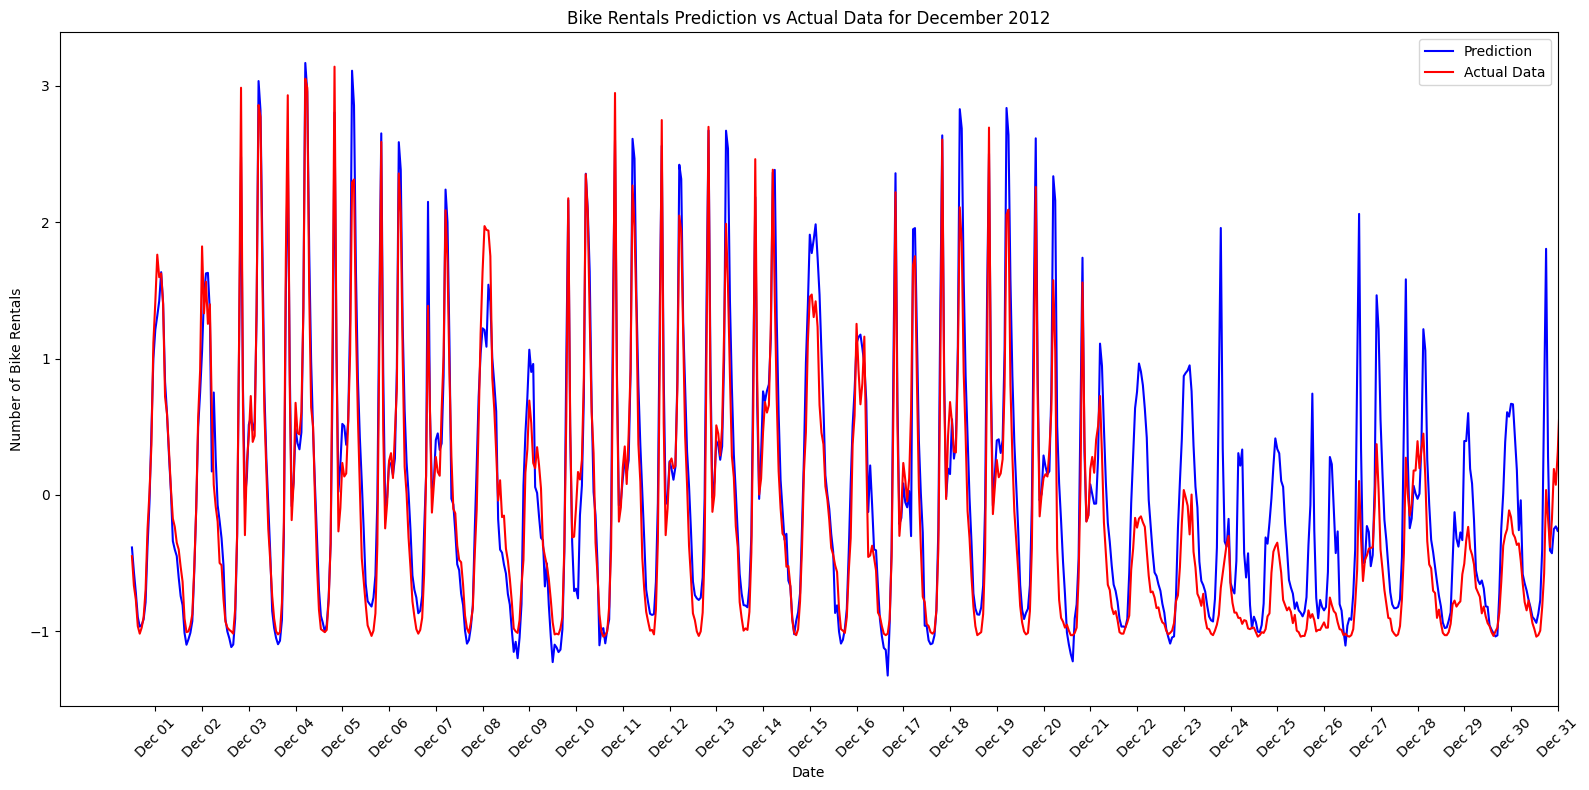

In [45]:
fig, ax = plt.subplots(figsize=(16, 8))

# De-normalize the predictions and actual targets to original scale
mean, std = normalization_info['cnt']
predictions_denorm = network.run(test_features).T * std + mean
actuals_denorm = (test_targets['cnt'] * std + mean).values

# Plotting the predictions and actual values
ax.plot(predictions_denorm[0], label='Prediction', color='blue')
ax.plot(actuals_denorm, label='Actual Data', color='red')

# Setting plot limits and labels
ax.set_xlim(right=len(predictions_denorm))
ax.legend()
ax.set_title("Bike Rentals Prediction vs Actual Data for December 2012")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Bike Rentals")

# Formatting date ticks on x-axis
dates = pd.to_datetime(ride_data.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
ax.set_xticklabels(dates[12::24], rotation=45)

plt.tight_layout()
plt.show()

**Insights:**

In observing the neural network's predictions, there is a notable deviation from the actual data during the last 10 days of December. This period, which encompasses significant holidays such as Christmas and New Year's Eve, traditionally sees non-standard behaviors in bike rentals due to its festive nature and varying public activities. The neural network's difficulty in predicting this irregular pattern accurately may stem from a lack of extensive training data that captures the nuances of such holiday seasons.

In essence, while our network has been trained on historical data, the unique patterns exhibited during holiday seasons might not be sufficiently represented.

This results in the model failing to generalize well for this specific timeframe. It underscores the challenge in machine learning where rare events or underrepresented patterns, despite their significance, can lead to prediction inaccuracies. Enhancing the model's performance for such periods would likely require targeted approaches, including augmenting training data with more holiday seasons, introducing specialized features to flag such events, or even considering hybrid models that combine data-driven predictions with rule-based adjustments for known anomalies.
